In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import block_diag
from numpy.linalg import multi_dot
from scipy.linalg import sqrtm
import os

In [2]:
N_TRIAL = 6000
N_ARMS = 100
K = 3
N_FEATURE = 3
M = 4

In [3]:
Beta = np.genfromtxt('Beta.csv',delimiter=',')
X_1 = np.genfromtxt('X.csv',delimiter=',')
Y_1 = np.genfromtxt('Y.csv',delimiter=',')
E = np.genfromtxt('E.csv',delimiter=',')

# Q = np.genfromtxt('Q.csv',delimiter=',')
# C = np.genfromtxt('C.csv',delimiter=',')
# W = np.genfromtxt('W.csv',delimiter=',') #E
# E2 = np.genfromtxt('E(100).csv',delimiter=',')

In [4]:
# Initialize q and C
# vec_q: q (Kp x 1)
np.random.seed(3)
vec_q = np.array([np.random.rand() for _ in range(K * N_FEATURE)])

# vec_C: C (NK x 1)
np.random.seed(42)
norm_C = []
for t in range(N_ARMS):
    vector = np.array([np.random.rand() for _ in range(K)])
    for i in range(len(vector)):
        norm_C.append(vector[i] / sum(vector))
vec_C = np.array(norm_C)

In [5]:
# c normalization
def normalize_c(C, n_arms, K):
    vectorNormalized = []
    matrix_c = C.reshape(n_arms, K)
    for t in range(N_ARMS):
        if sum(matrix_c[t]) == 0:
            for i in range(len(matrix_c[t])):
                vectorNormalized.append(matrix_c[t, i])
        else:
            for i in range(len(matrix_c[t])):
                vectorNormalized.append(matrix_c[t, i] / sum(matrix_c[t]))
    return np.array(vectorNormalized)

# truncate negative elements/ shifting negative elements to 0
# def zeroed(arr):
#     return arr.clip(min=0)

# def shifted(arr):
#     return arr + abs(np.min(arr))

In [6]:
# X transformation from a sparse matrix
def X_reshape(X, X_tr, t, K, n_arms, n_feature):  #
  for arm in range(1, n_arms):
    X_tr = np.concatenate((X_tr,np.kron(np.identity(n = K),X[arm].reshape(-1,1))), axis = 1)
  return X_tr

# convert to a sparse matrix
def X_to_X_m(X, t, arm_choice, n_arms, n_feature):
  X_m = np.copy(X[t])
  for arm in np.arange(n_arms): # N x p
    if arm not in arm_choice:
      X_m[arm] = np.zeros(shape=n_feature)
  return X_m

In [7]:
def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [8]:
def make_l2_norm_diff(l2_norm, t_l2_norm, arm_choice):
    diff = []
    for t in range(len(l2_norm)):
        diff_t = np.sum([t_l2_norm[choice] for choice in arm_choice[t]]) - l2_norm[t] 
        diff.append(diff_t)
    return np.array(diff)
def plot_l2_norm_diff(results, t_l2_norm):
    [plt.plot(make_l2_norm_diff(x['l2_norm'], t_l2_norm, x['arm_choice']), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [9]:
#eta_1, eta_2, lambda = tuning param.
#alpha_q, alpha_c = upper bound for q and C
#X = feature matrix
#Y = true reward matrix
#E = laplacian matrix
#m = number of selected arms
#K = number of latent structures

def CoCoUCB(eta_1, eta_2, alpha_q, alpha_c, lda, X, Y, init_q, init_c, m, K, E, X_to_X_m, X_reshape):
    print("CoCoUCB with eta_1:", eta_1, "eta_2:", eta_2, "alpha_q:", alpha_q, "alpha_c:", alpha_c)
    n_trial, n_arms, n_feature = X.shape
    #n_arms = N | n_trial = t | n_features = p | K

    # 1. Initialize objects
    # 1.1. Output objects                     
    arm_choice = np.empty(shape=(n_trial, m), dtype=int)
    r_payoff = np.empty(n_trial)                                  
    p = np.empty(shape=(n_trial, n_arms))                         
    
    # 1.2. F calculation

    F = np.diag(np.ones(shape=n_arms)) + lda * E
    F_kron = np.kron(F, np.diag(np.ones(shape=K)))
    FInv = sqrtm(np.linalg.inv(np.kron(F, np.identity(n=K))))
    F_sqrt = sqrtm(np.kron(F, np.identity(n=K)))
    
    # 1.3. Intialize q and C_tilde
    q = np.empty(shape = (n_trial + 1, K * n_feature)) #Kp x 1
    C_tilde = np.empty(shape = (n_trial + 1, n_arms * K)) #NK x 1
    q[0] = init_q
    C_tilde[0] = init_c
    
    # 1.4. A, b, D, d
    A = eta_1 * np.identity(n = K * n_feature) #Kp x Kp
    b = np.zeros(shape=K * n_feature)         #Kp x 1
    D = eta_2 * np.identity(n = n_arms * K) #NK x NK
    d = np.zeros(shape=n_arms * K)         #NK x 1
    inv_A = np.linalg.inv(A)
    inv_D = np.linalg.inv(D)
    
    # 2. Algorithm
    for t in np.arange(n_trial):
#         print('trial:',t, 'C_tilde:', C_tilde[t])
        for a in np.arange(n_arms):
          #X transformations
          X_temp = X_to_X_m(X, t, [a], n_arms, n_feature)
          X_tr_init = np.kron(np.identity(n = K),X_temp[0].reshape(-1,1))
          X_tr = X_reshape(X_temp, X_tr_init, t, K, n_arms, n_feature) #Kp x NK
          #Calculate cb_q and cb_c
          X_q_a = C_tilde[t].dot(X_tr.T)
          cb_q = alpha_q * np.sqrt(X_q_a.T.dot(inv_A).dot(X_q_a))
          X_c = (X_tr.dot(FInv)).T.dot(q[t])
          cb_c = alpha_c * np.sqrt((X_c).T.dot(inv_D).dot(X_c)) #.clip(0)
          #Predictions
          p[t, a] = (C_tilde[t].T).dot(X_tr.T).dot(q[t]) + cb_q + cb_c

        # Choose m best arms
        idx = np.argpartition(p[t], -m)[-m:]
        chosen_arms = idx[np.argsort((-p[t])[idx])] #choose m arms that give highest p
        for i in np.arange(m):
          arm_choice[t][i] = chosen_arms[i]
        
        #Update intermediate objects (A, b, D, d)
        for chosen_arm in arm_choice[t]:
          #X transformations
          X_tr_chosen_temp = X_to_X_m(X_1, t, [chosen_arm], n_arms, n_feature)
          X_tr_init_cs = np.kron(np.identity(n = K),X_tr_chosen_temp[0].reshape(-1,1))
          X_1_tr_chosen =  X_reshape(X_tr_chosen_temp, X_tr_init_cs, t, K, n_arms, n_feature)
          X_q = C_tilde[t].dot(X_1_tr_chosen.T) # need diff transformation for X_q?
          X_C_Tilde = (FInv.T).dot(X_1_tr_chosen.T.dot(q[t]))
          A = A + np.outer(X_q, X_q)
          b = b + Y[t, chosen_arm] * X_q
          D = D + np.outer(X_C_Tilde, X_C_Tilde)           
          d = d + Y[t, chosen_arm] * X_C_Tilde
        inv_A = np.linalg.inv(A)
        inv_D = np.linalg.inv(D)
        q[t + 1] = inv_A.dot(b)
#         C_temp = np.abs(inv_D.dot(d)) # np.abs() --> truncating or shifting instead
        C_temp = ((inv_D.dot(d)).clip(0))
        C_tilde[t + 1] = normalize_c(C_temp, n_arms, K) #normalize
        r_payoff[t]   = np.sum([Y[t, choice] for choice in arm_choice[t]])
        
        if t % 500 == 0:
            print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
    return dict(q = q, C_tilde = C_tilde, p = p, arm_choice = arm_choice, r_payoff = r_payoff)

In [10]:
#create X_{it} = [1,t, t^2]
X_1_lst = []
for T in np.arange(N_TRIAL):
  X_1t_lst = []
  for arm in np.arange(N_ARMS):
    temp = []
    temp.append(1)
    temp.append(0.001*(T+1))
    temp.append((0.001*(T+1))**2)
    X_1t_lst.append(np.array(temp))
    # np.append(X_1, X_1t)
  X_1_lst.append(np.array(X_1t_lst))
X_1 = np.array(X_1_lst)

In [11]:
# True M highest rewards  
oracle_lst = []
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [Y_1.T[t, arm] for arm in np.arange(N_ARMS)]
  idx = np.argpartition(all_reward_t, -M)[-M:]
  chosen_arms = idx[np.argsort((-np.array(all_reward_t))[idx])]
  # Sum of M highest rewards
  oracle_payoff_t = np.sum([Y_1.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
#   print(chosen_arms)
oracle_case1 = np.array(oracle_lst)

In [12]:
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
# alpha_to_test = [0, 1, 2.5, 5, 10, 20]
results_dict = {alpha: CoCoUCB(eta_1 = 0.3, eta_2 = 0.3, alpha_q = 20, alpha_c = alpha, lda = 10, X=X_1, Y=Y_1.T, init_q=vec_q, init_c=vec_C,m=M, K = K, E=E, X_to_X_m=X_to_X_m, X_reshape=X_reshape)\
                for alpha in alpha_to_test}

CoCoUCB with eta_1: 0.3 eta_2: 0.3 alpha_q: 20 alpha_c: 0


C:\Users\ARTY\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\ARTY\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: ComplexWarning: Casting complex values to real discards the imaginary part


TRIAL: 0 DONE | arm selected: [68 33 69 22]
TRIAL: 500 DONE | arm selected: [19 11 89 48]
TRIAL: 1000 DONE | arm selected: [89 73 79 19]
TRIAL: 1500 DONE | arm selected: [39 73 79  9]
TRIAL: 2000 DONE | arm selected: [39 23 17  9]
TRIAL: 2500 DONE | arm selected: [60 11 19 85]
TRIAL: 3000 DONE | arm selected: [19 11 60 85]
TRIAL: 3500 DONE | arm selected: [19 11 60 85]
TRIAL: 4000 DONE | arm selected: [19 11 71 85]
TRIAL: 4500 DONE | arm selected: [19 11 71  9]
TRIAL: 5000 DONE | arm selected: [19 71 11  9]
TRIAL: 5500 DONE | arm selected: [19 71 11 85]
CoCoUCB with eta_1: 0.3 eta_2: 0.3 alpha_q: 20 alpha_c: 1
TRIAL: 0 DONE | arm selected: [68 33 69 22]
TRIAL: 500 DONE | arm selected: [89 59  8 55]
TRIAL: 1000 DONE | arm selected: [82  4  1 75]
TRIAL: 1500 DONE | arm selected: [54 59 60  8]
TRIAL: 2000 DONE | arm selected: [35 26 24 89]
TRIAL: 2500 DONE | arm selected: [35 26 38 54]
TRIAL: 3000 DONE | arm selected: [38 35 54 44]
TRIAL: 3500 DONE | arm selected: [38 35 54 44]
TRIAL: 400

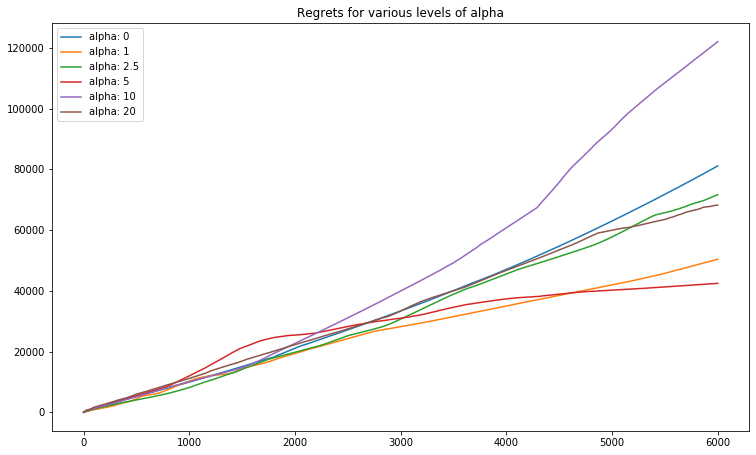

In [13]:
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
# plt.plot(make_regret(payoff=payoff_random, oracle=oracle_case1), label = "random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [14]:
# Plot l2-difference
#True Beta
Beta_reshape = Beta.T
# t_l2_norm_lst = []
# for i in range (N_ARMS):
#     t_l2_norm_lst.append(np.linalg.norm(Beta_reshape[i], ord=2))
# t_l2_norm = np.array(t_l2_norm_lst)